In [4]:
import robotic as ry
import time
def find_rrt_path(C, start, goal):
    print("Running RRT for pathfinding...")
    rrt_solver = ry.PathFinder()
    rrt_solver.setProblem(C, [start], [goal])  
    result = rrt_solver.solve()
    if result is not None and result.x is not None:
        print("Feasible path found!")
        return result.x  
    else:
        print("No feasible path found.")
        return None

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 111 of `/tmp/ipykernel_270005/1620226502.py`, you are using the following planning engine:
  * Engine name: pyperplan
  * Developers:  Albert-Ludwigs-Universität Freiburg (Yusra Alkhazraji, Matthias Frorath, Markus Grützner, Malte Helmert, Thomas Liebetraut, Robert Mattmüller, Manuela Ortlieb, Jendrik Seipp, Tobias Springenberg, Philip Stahl, Jan Wülfing)
  * Description: Pyperplan is a lightweight STRIPS planner written in Python.

Plan found:
pick(tray2, table, gripper)
pick(particle2, table, sponge)
place(particle2, dustbin, sponge)
pick(particle1, table, sponge)
place(particle1, dustbin, sponge)
place(tray2, bin1, gripper)
pick(mug, table, gripper)
place(mug, bin1, gripper)
pick(tray1, table, gripper)
place(tray1, bin1, gripper)
allow_wiping
wipe(table, sponge)


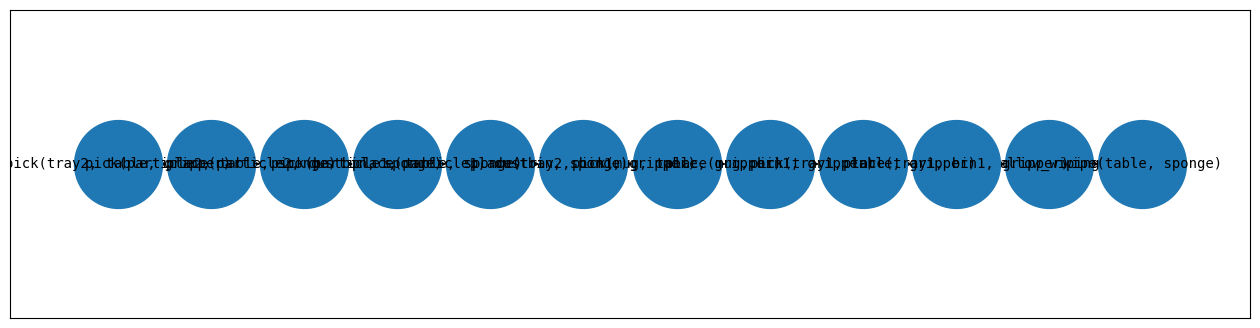

In [5]:
# PDDL = Planning Domain Definition Language

from unified_planning.shortcuts import *
from unified_planning.plot import plot_sequential_plan
from inspect import getmembers, isfunction
from functools import partial
import os, uuid, tempfile as tf

Location = UserType("Location") # User Types
Object = UserType("Object")
Tool = UserType("Tool")

on = Fluent("on", BoolType(), obj=Object, loc=Location) # Fluents
dirty = Fluent("dirty", BoolType(), loc=Location)
clean = Fluent("clean", BoolType(), loc=Location)
holding = Fluent("holding", BoolType(), tool=Tool)
clear = Fluent("clear", BoolType(), loc=Location)
usable_tool = Fluent("usable_tool", BoolType(), obj=Object, tool=Tool)
can_wipe = Fluent("can_wipe", BoolType(), tool=Tool) 
wiping_allowed = Fluent("wiping_allowed", BoolType()) 

pick = InstantaneousAction("pick", obj=Object, loc=Location, tool=Tool) # Action: Pick
pick_obj, pick_loc, pick_tool = pick.parameters
pick.add_precondition(on(pick_obj, pick_loc))       
pick.add_precondition(clear(pick_loc))             
pick.add_precondition(usable_tool(pick_obj, pick_tool))  
pick.add_effect(on(pick_obj, pick_loc), False)
pick.add_effect(holding(pick_tool), True)

place = InstantaneousAction("place", obj=Object, loc=Location, tool=Tool) # Action: Place
place_obj, place_loc, place_tool = place.parameters
place.add_precondition(holding(place_tool))            
place.add_precondition(usable_tool(place_obj, place_tool)) 
place.add_effect(holding(place_tool), False)
place.add_effect(on(place_obj, place_loc), True)

wipe = InstantaneousAction("wipe", loc=Location, tool=Tool) # Action: Wipe
wipe_loc, wipe_tool = wipe.parameters
wipe.add_precondition(dirty(wipe_loc))        
wipe.add_precondition(can_wipe(wipe_tool))    
wipe.add_precondition(wiping_allowed)        
wipe.add_effect(dirty(wipe_loc), False)
wipe.add_effect(clean(wipe_loc), True)

problem = Problem("table_cleaning") # Problem
problem.add_fluent(on, default_initial_value=False)
problem.add_fluent(dirty, default_initial_value=False)
problem.add_fluent(clean, default_initial_value=False)
problem.add_fluent(holding, default_initial_value=False)
problem.add_fluent(clear, default_initial_value=True)
problem.add_fluent(usable_tool, default_initial_value=False)
problem.add_fluent(can_wipe, default_initial_value=False)
problem.add_fluent(wiping_allowed, default_initial_value=False)  # Wiping initially not allowed

problem.add_action(pick) # Add Actions
problem.add_action(place)
problem.add_action(wipe)

tray1 = unified_planning.model.Object("tray1", Object) # Define Objects
tray2 = unified_planning.model.Object("tray2", Object)
mug = unified_planning.model.Object("mug", Object)
particle1 = unified_planning.model.Object("particle1", Object)
particle2 = unified_planning.model.Object("particle2", Object)
sponge = unified_planning.model.Object("sponge", Tool)
gripper = unified_planning.model.Object("gripper", Tool)
table = unified_planning.model.Object("table", Location)
bin1 = unified_planning.model.Object("bin1", Location)
dustbin = unified_planning.model.Object("dustbin", Location)
problem.add_objects([tray1, tray2, mug, particle1, particle2, sponge, gripper, table, bin1, dustbin])

problem.set_initial_value(on(tray1, table), True) # Initial State
problem.set_initial_value(on(tray2, table), True)
problem.set_initial_value(on(mug, table), True)
problem.set_initial_value(on(particle1, table), True)
problem.set_initial_value(on(particle2, table), True)
problem.set_initial_value(dirty(table), True)
problem.set_initial_value(clear(bin1), True)
problem.set_initial_value(clear(dustbin), True)
problem.set_initial_value(holding(sponge), False)
problem.set_initial_value(holding(gripper), False)
problem.set_initial_value(wiping_allowed, False) 

problem.set_initial_value(usable_tool(particle1, sponge), True) # tool constraints
problem.set_initial_value(usable_tool(particle2, sponge), True)
problem.set_initial_value(usable_tool(particle1, gripper), False)
problem.set_initial_value(usable_tool(particle2, gripper), False)
problem.set_initial_value(usable_tool(tray1, sponge), False)
problem.set_initial_value(usable_tool(tray2, sponge), False)
problem.set_initial_value(usable_tool(mug, sponge), False)
problem.set_initial_value(usable_tool(tray1, gripper), True)
problem.set_initial_value(usable_tool(tray2, gripper), True)
problem.set_initial_value(usable_tool(mug, gripper), True)
problem.set_initial_value(can_wipe(sponge), True) 
problem.set_initial_value(can_wipe(gripper), False)  

problem.add_goal(on(tray1, bin1)) # Goals
problem.add_goal(on(tray2, bin1))
problem.add_goal(on(mug, bin1))
problem.add_goal(on(particle1, dustbin))  
problem.add_goal(on(particle2, dustbin))  
problem.add_goal(clean(table))          
allow_wiping = InstantaneousAction("allow_wiping")
allow_wiping.add_precondition(on(tray1, bin1))
allow_wiping.add_precondition(on(tray2, bin1))
allow_wiping.add_precondition(on(mug, bin1))
allow_wiping.add_precondition(on(particle1, dustbin))
allow_wiping.add_precondition(on(particle2, dustbin))
allow_wiping.add_effect(wiping_allowed, True)
problem.add_action(allow_wiping)

with OneshotPlanner(name="pyperplan") as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Plan found:")
        for action in result.plan.actions:
            print(action)
        plan = result.plan
        if plan is not None:
            plot_sequential_plan(plan, figsize=(16, 4), node_size=4000, font_size=10)
    else:
        print("No plan found.")
        plan = None


In [ ]:
if plan:
    C = ry.Config()
    C.addFile(ry.raiPath('../rai-robotModels/task.g'))
    C.view()

    for action_instance in plan.actions:
        action_name = action_instance.action.name  
        parameters = action_instance.actual_parameters  

        if action_name == "pick":
            obj, loc, tool = [str(p.object()) for p in parameters]
            names = C.getFrameNames()
            print("names",names)
            print(" obj, loc, tool", obj, loc, tool)  
            start = C.frame(tool).getPosition()
            goal = C.frame(loc).getPosition()
            rrt_path = find_rrt_path(C, start, goal)
            if rrt_path:
                for state in rrt_path:
                    C.setJointState(state)
                    C.view()
                    time.sleep(0.1)
        elif action_name == "place":
            obj, loc, tool = [str(p.object()) for p in parameters]  
            start = C.frame(tool).getPosition()
            goal = C.frame(loc).getPosition()
            rrt_path = find_rrt_path(C, start, goal)
            if rrt_path:
                for state in rrt_path:
                    C.setJointState(state)
                    C.view()
                    time.sleep(0.1)
        elif action_name == "wipe":
            loc, tool = [str(p.object()) for p in parameters]  
            start = C.frame(tool).getPosition()
            goal = C.frame(loc).getPosition()
            rrt_path = find_rrt_path(C, start, goal)
            if rrt_path:
                for state in rrt_path:
                    C.setJointState(state)
                    C.view()
                    time.sleep(0.1)

 obj, loc, tool tray2 table gripper
-- WARNING:kin.cpp:getFrame:415(-1) cannot find frame named 'gripper'
-- WARNING:RenderData.cpp:glInitialize:105(-1) FreeType Error: Failed to load font 'ubuntu/Ubuntu-L.ttf' error code: 1 -> text rendering disabled


AttributeError: 'NoneType' object has no attribute 'getPosition'